In [1]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')  # Customer data
transactions = pd.read_csv('Transactions.csv')  # Transaction data

# Merge datasets on CustomerID
data = transactions.merge(customers, on='CustomerID')

# Preview the merged dataset
print(data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00761      C0199      P022  2024-10-01 05:57:09         4   
2        T00626      C0199      P079  2024-08-17 12:06:08         2   
3        T00963      C0199      P008  2024-10-26 00:01:58         2   
4        T00112      C0146      P067  2024-05-27 22:23:54         1   

   TotalValue   Price     CustomerName  Region  SignupDate  
0      300.68  300.68   Andrea Jenkins  Europe  2022-12-03  
1      550.16  137.54   Andrea Jenkins  Europe  2022-12-03  
2      834.74  417.37   Andrea Jenkins  Europe  2022-12-03  
3      293.70  146.85   Andrea Jenkins  Europe  2022-12-03  
4      300.68  300.68  Brittany Harvey    Asia  2024-09-04  


In [2]:
from datetime import datetime

# Calculate days since sign-up
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['days_since_signup'] = (datetime.now() - customers['SignupDate']).dt.days

# Aggregate transaction data by CustomerID
customer_features = data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count')
).reset_index()

# Add days since sign-up and one-hot encode Region
region_features = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'])
customer_features = customer_features.merge(region_features, on='CustomerID').merge(
    customers[['CustomerID', 'days_since_signup']], on='CustomerID'
)

print(customer_features.head())


  CustomerID  total_spent  total_quantity  avg_transaction_value  \
0      C0001      3354.52              12                670.904   
1      C0002      1862.74              10                465.685   
2      C0003      2725.38              14                681.345   
3      C0004      5354.88              23                669.360   
4      C0005      2034.24               7                678.080   

   transaction_count  Region_Asia  Region_Europe  Region_North America  \
0                  5        False          False                 False   
1                  4         True          False                 False   
2                  4        False          False                 False   
3                  8        False          False                 False   
4                  3         True          False                 False   

   Region_South America  days_since_signup  
0                  True                932  
1                 False               1079  
2          

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:])

# Create a DataFrame for normalized features
normalized_df = pd.DataFrame(scaled_features, columns=customer_features.columns[1:])
normalized_df['CustomerID'] = customer_features['CustomerID']

print(normalized_df.head())


   total_spent  total_quantity  avg_transaction_value  transaction_count  \
0     0.308942        0.354839               0.474336                0.4   
1     0.168095        0.290323               0.308940                0.3   
2     0.249541        0.419355               0.482751                0.3   
3     0.497806        0.709677               0.473092                0.7   
4     0.184287        0.193548               0.480120                0.2   

   Region_Asia  Region_Europe  Region_North America  Region_South America  \
0          0.0            0.0                   0.0                   1.0   
1          1.0            0.0                   0.0                   0.0   
2          0.0            0.0                   0.0                   1.0   
3          0.0            0.0                   0.0                   1.0   
4          1.0            0.0                   0.0                   0.0   

   days_since_signup CustomerID  
0           0.842204      C0001  
1           

In [20]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

c:\Users\vivus\.conda\envs\GenAi_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vivus\.conda\envs\GenAi_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vivus\.conda\envs\GenAi_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vivus\.conda\envs\GenAi_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

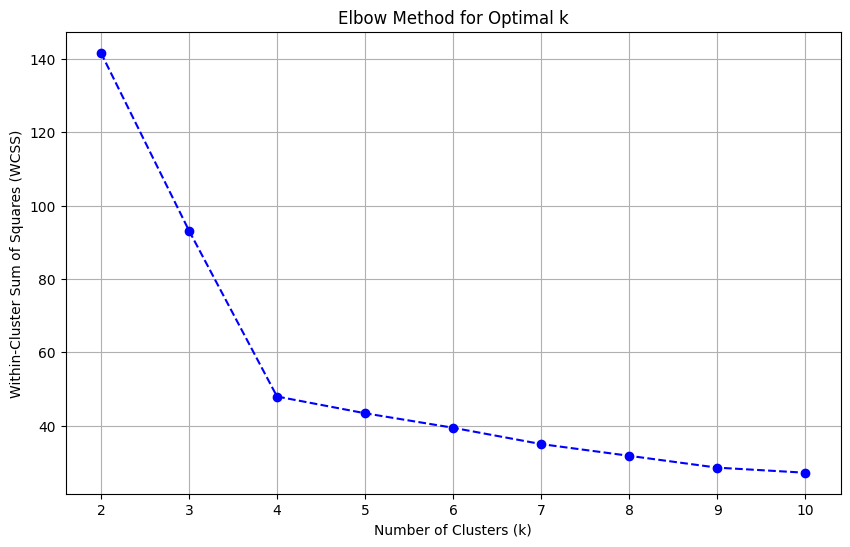

In [21]:
# Step 4: Elbow Method to Find Optimal Number of Clusters
wcss = []  # To store Within-Cluster Sum of Squares for each k
k_range = range(2, 11)  # Testing k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)  # Fit the KMeans algorithm to the data
    wcss.append(kmeans.inertia_)  # Append WCSS (inertia)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [22]:

# Perform clustering with KMeans
num_clusters = 4 # Adjust based on DB Index and elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the DataFrame
customer_features['Cluster'] = cluster_labels

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.6603488186140981


c:\Users\vivus\.conda\envs\GenAi_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


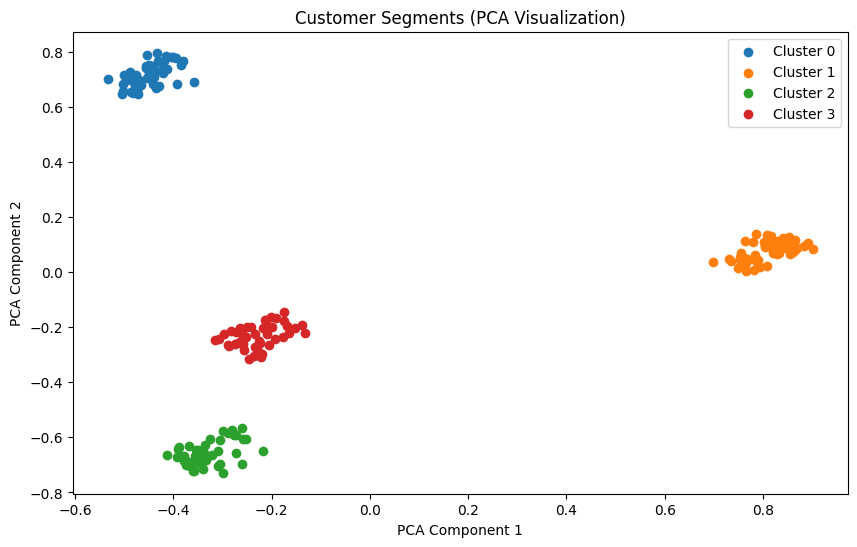

In [23]:

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_data = reduced_features[cluster_labels == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [25]:
# Save Clustering Results
customer_features.to_csv('Customer_Segments.csv', index=False)
print("\nClustering results saved to 'Customer_Segments.csv'")


Clustering results saved to 'Customer_Segments.csv'


In [27]:
print(customer_features.dtypes)


CustomerID                object
total_spent              float64
total_quantity             int64
avg_transaction_value    float64
transaction_count          int64
Region_Asia                 bool
Region_Europe               bool
Region_North America        bool
Region_South America        bool
days_since_signup          int64
Cluster                    int32
dtype: object


In [28]:
# Analyze cluster characteristics
# Exclude non-numeric columns like 'CustomerID'
numeric_columns = customer_features.drop(columns=['CustomerID'], errors='ignore')

# Group by 'Cluster' and calculate the mean for numeric columns
cluster_analysis = numeric_columns.groupby('Cluster').mean()

print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
         total_spent  total_quantity  avg_transaction_value  \
Cluster                                                       
0        3325.092600       11.900000             696.301203   
1        3717.840000       13.372881             700.667556   
2        3311.160870       12.891304             639.956633   
3        3456.249318       12.727273             709.909207   

         transaction_count  Region_Asia  Region_Europe  Region_North America  \
Cluster                                                                        
0                 4.680000          0.0            1.0                   0.0   
1                 5.152542          0.0            0.0                   0.0   
2                 5.304348          0.0            0.0                   1.0   
3                 4.954545          1.0            0.0                   0.0   

         Region_South America  days_since_signup  
Cluster                                           
0                  